In [2]:
import torch
from elasticsearch import Elasticsearch
import numpy as np
import pandas as pd
import hashlib
from tqdm import tqdm
import os
import base64
from PIL import Image
import io
from dataProcessor import process_metadata, pew_metadata_path, statista_metadata_path
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
import torch
import torch.nn.functional as F
from torch import Tensor

/home/mleshashi/thesis-sharma/sraEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#  get the combined dataframe
combined_df = process_metadata(pew_metadata_path, statista_metadata_path)
combined_df.shape

(29354, 4)

In [5]:
# Function to encode image to Base64
def image_to_base64(image_path):
    with open(image_path, "rb") as img_file:
        # Read the image file
        img_bytes = img_file.read()
        # Encode image bytes to Base64
        base64_img = base64.b64encode(img_bytes).decode("utf-8")
        return base64_img

In [6]:
# Define the quantization configuration
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# Load the tokenizer and quantized model
tokenizer = AutoTokenizer.from_pretrained('intfloat/e5-mistral-7b-instruct')
model = AutoModel.from_pretrained(
    'intfloat/e5-mistral-7b-instruct',
    quantization_config=quantization_config,
    device_map="auto"
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.31s/it]


In [7]:
# Correctly formatted URL for a local Elasticsearch instance
es = Elasticsearch(["http://localhost:9200"])

# define the index name
index_name = "documents"

In [8]:
if not es.indices.exists(index=index_name):
    es.indices.create(index=index_name, body={
        "mappings": {
            "properties": {
                "title": {"type": "text"},
                "content": {"type": "text"},
                "image_data": {"type": "text"},  # Storing Base64-encoded image data
                "mistral_embedding": {"type": "dense_vector", "dims": 4096}
            }
        }
    })

In [9]:
# Ensure inputs are moved to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move the model to the appropriate device if needed
print(f"Model is on device: {next(model.parameters()).device}")

# Define the maximum length for the input text
max_length = 1250

Using device: cuda
Model is on device: cuda:0


In [10]:
# Function to perform last token pooling on hidden states based on the attention mask.
# It handles cases with left or right padding.
def last_token_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]
    
    
# Function to format a detailed instruction string from a task description and query.
def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery: {query}'

# Function to embed texts
def embed_texts(texts):
    input_token = tokenizer(texts, max_length=max_length, padding=True, truncation=True, return_tensors='pt')
    input_token = {k: v.to(device) for k, v in input_token.items()}
    with torch.no_grad():  # Ensure no gradients are calculated
        outputs = model(**input_token)
        embeddings = last_token_pool(outputs.last_hidden_state, input_token['attention_mask'])
        embeddings = F.normalize(embeddings, p=2, dim=1)
    return embeddings.detach().cpu().numpy().flatten().tolist()

In [11]:
# Indexing the documents into embeddings using Elasticsearch with its unique ID, ensuring no duplicates are created.
for _, row in tqdm(combined_df.iterrows(), total=combined_df.shape[0]):
    # Concatenate title and caption with a space or some delimiter
    combined_text = f"{row['title']}. {row['caption']}"
    
    # Generate embedding for the combined text
    embedding = embed_texts(combined_text)

    # Generate a unique ID for the document using a hash of the title and caption
    unique_id = hashlib.sha256(combined_text.encode('utf-8')).hexdigest()
    
    # Get Base64-encoded image data
    image_path = row['imgPath']
    base64_image_data = image_to_base64(image_path)
    
    # Index the document with the combined embedding, image data, and use the unique_id as the document ID
    es.index(index=index_name, id=unique_id, body={
        "title": row['title'],
        "content": row['caption'],
        "image_data": base64_image_data,
        "mistral_embedding": embedding
    })
    
    # Clear CUDA cache
    torch.cuda.empty_cache()

    # Optional: Clear variables if no longer needed
    del combined_text, embedding, image_path, base64_image_data

100%|██████████| 29354/29354 [2:18:30<00:00,  3.53it/s]  


In [12]:
doc_count = es.count(index=index_name)['count']
print(f"Number of documents in the index: {doc_count}")

Number of documents in the index: 29348


In [13]:
# Define the task description
task = 'Given a web search query, retrieve relevant passages that answer the query'

# Assuming initialization and index creation as before
topics_df = pd.read_csv('../dataset/topics.csv')

# Dictionary to hold total similarity scores for each topic
topic_similarity_scores = {}

for _, row in topics_df.iterrows():
    question = row['Topic']
    query = get_detailed_instruct(task, question)
    query_embedding = embed_texts(query)
    script_query = {
        "script_score": {
            "query": {"match_all": {}},
            "script": {
                "source": "cosineSimilarity(params.query_vector, 'mistral_embedding') + 1.0",
                "params": {"query_vector": query_embedding}
            }
        }
    }
    
    response = es.search(index=index_name, body={
        "size": 10000,  # You might want to adjust this size based on your needs
        "query": script_query,
        "_source": {"includes": ["title", "content", "image_data"]}  # Include the image data in the response
    })

    # Sum up the scores of all hits for this topic
    total_score = sum(hit['_score'] for hit in response['hits']['hits'])
    topic_similarity_scores[question] = total_score

    # Rank topics by their total similarity score
sorted_topics = sorted(topic_similarity_scores.items(), key=lambda x: x[1], reverse=True)

In [14]:
# Output the top 10 relevant topics
print("Top 10 Relevant Topics Based on Similarity Score:")
for i, (topic, score) in enumerate(sorted_topics[:30], 1):
    print(f"{i}. Topic: {topic}, Total Similarity Score: {score}")


Top 10 Relevant Topics Based on Similarity Score:
1. Topic: Are gas prices too high?, Total Similarity Score: 15892.22448599997
2. Topic: Is a college education worth it?, Total Similarity Score: 15846.739193499992
3. Topic: Is capitalism the best form of economy?, Total Similarity Score: 15768.93202590005
4. Topic: Do we need cash?, Total Similarity Score: 15748.53385359994
5. Topic: Should education be free?, Total Similarity Score: 15722.433332799998
6. Topic: Does lowering the federal corporate income tax rate create jobs?, Total Similarity Score: 15698.480079599938
7. Topic: Should everyone get a universal basic income?, Total Similarity Score: 15689.013965900003
8. Topic: Should the press be subsidized?, Total Similarity Score: 15666.392769999991
9. Topic: Should the penny stay in circulation?, Total Similarity Score: 15656.648957799938
10. Topic: Should government spending be reduced?, Total Similarity Score: 15642.625136100007
11. Topic: Should blood donations be financially co

In [15]:
# Create a DataFrame with the top relevant topics and their similarity scores
topics_df = pd.DataFrame(sorted_topics[:30], columns=['Topic', 'Similarity Score'])
# Specify the full path for saving the CSV file
csv_path = '../dataset/TopRelevant_topics1.csv'
# Save the DataFrame to the specified CSV file path
topics_df.to_csv(csv_path, index=False)

print("Top relevant topics saved to TopRelevant_topics.csv")

Top relevant topics saved to TopRelevant_topics.csv


***Retriving the top context from a random topic***

In [16]:
# Select a random topic
import random   
question = random.choice(topics_df['Topic'].to_list())

# Define the task description
task = 'Given a web search query, retrieve relevant passages that answer the query'

# Generate the detailed instruction string
query = get_detailed_instruct(task, question)
query_embedding = embed_texts(query)

# Define the script query for Elasticsearch
query

'Instruct: Given a web search query, retrieve relevant passages that answer the query\nQuery: Should we imprison fewer people?'

Top 3 relevant documents for the topic 'Should we imprison fewer people?':

1. Title: U.S. imprisonment rate has been on the decline since the late 2000s Prisoners per 100,000 adults ages 18 and older
   Content: Overall, the U.S. imprisonment rate has been on a downward trajectory for the past decade, though the country still has the highest incarceration rate in the world. Counting all races and ethnicities, the U.S. imprisonment rate fell 17% between 2006 and 2018, from 666 prisoners per 100,000 adults to 555 per 100,000. The imprisonment rate at the end of 2018 was about the same level as in 1995, when there were 556 prisoners for every 100,000 adults.
   Score: 73.58065



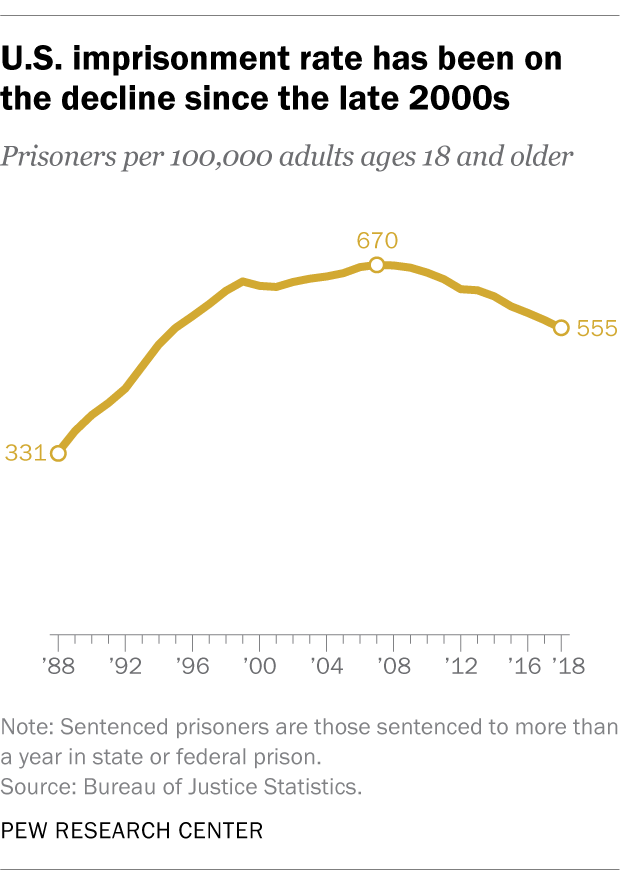

2. Title: growth, incarceration in U.S. has waned Number of people incarcerated (in millions)
   Content: The U.S. incarceration rate fell in 2016 to its lowest level in 20 years, according to new data from the Bureau of Justice Statistics (BJS), the statistical arm of the Department of Justice. Despite the decline, the United States incarcerates a larger share of its population than any other country.
At the end of 2016, there were about 2.2 million people behind bars in the U.S., including 1.5 million under the jurisdiction of federal and state prisons and roughly 741,000 in the custody of locally run jails. That amounts to a nationwide incarceration rate of 860 prison or jail inmates for every 100,000 adults ages 18 and older.
The nation’s incarceration rate peaked at 1,000 inmates per 100,000 adults during the three-year period between 2006 and 2008. It has declined every year since then and is now at its lowest point since 1996, when there were 830 inmates per 100,000 adults.
   S

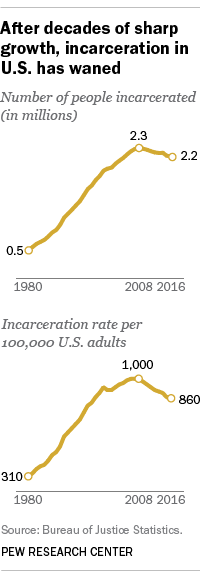

3. Title: 
                        Number of people sentenced to imprisonment in Denmark in 2019, by length of sentence
                    
   Content:  1,380 people were sentenced to spend between 31 and 60 days in prison in Denmark in 2019. Furthermore, 10 people had to spend 12 years or more in prison, while two people were sentenced to imprisonment for life. 
   Score: 69.32611



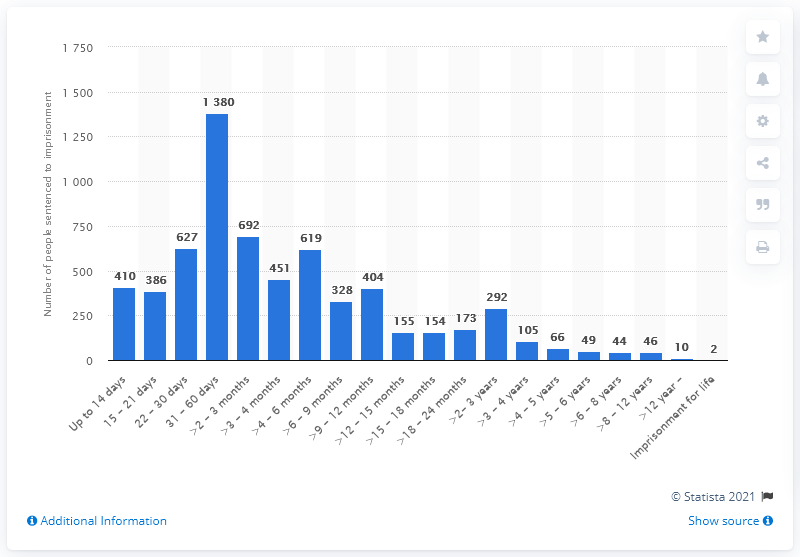

In [17]:
# Elasticsearch query to find relevant documents based on cosine similarity
script_query = {
    "script_score": {
        "query": {"match_all": {}},
        "script": {
            "source": "cosineSimilarity(params.query_vector, 'mistral_embedding') * 100.0",
            "params": {"query_vector": query_embedding}
        }
    }
}
    
# Execute the search query
response = es.search(index=index_name, body={
    "size": 3,  # Fetch top 3 relevant documents
    "query": script_query,
    "_source": ["title", "content", "image_data"]  # Include image data if available
})

# Extract and print the top 3 relevant documents
print(f"Top 3 relevant documents for the topic '{question}':\n")

for i, hit in enumerate(response['hits']['hits'], start=1):
    doc = hit['_source']
    print(f"{i}. Title: {doc['title']}\n   Content: {doc['content']}\n   Score: {hit['_score']}\n")

    # Decode Base64-encoded image data
    image_bytes = base64.b64decode(doc['image_data'])
    
    # Open the image from bytes
    image = Image.open(io.BytesIO(image_bytes))
    
    # Display the image
    image.show()

In [3]:
# Clear CUDA cache
torch.cuda.empty_cache()